# Assignment 1: Data Collection & Preparation

In [ ]:
#Import required modules
import urllib.request
from lxml import etree
from io import StringIO, BytesIO
import csv
import re
from datetime import datetime
from time import mktime
import pandas as pd
import numpy as np

## Task 1: Source APIs
### First API
The first API chosen for this assignment was provided by http://developer.sportradar.com/, specifically, the international rugby API: http://developer.sportradar.com/files/indexRugby.html#rugby-api. The data collected from this API was the match data from the 2015/2016 rugby season for the four Irish provincial teams: Munster, Leinster, Connacht, Ulster.

Two endpoints within this API were used, the match schedule endpoint and the match summary endpoint which will be discussed further in the assignment. Due to rate limits, two API keys were used:

- API Key 1: qw4fzemh3xuwdpaxpk6jgca9

The key rate limits are:
- 1 call per second
- 1000 calls per month

There are other rate limits that will be discussed when relevant

### Second API
The second API used for this assignment was originally the official Twitter API. The data required for analysis was from 2015/2016 which the official Twitter API would classify as historical. For a particular username (Twitter account), *Munsterrugby* for example, the maximum number of tweets that can be retrieved is 3,200. This was not a sufficient allowance in order to retrieve tweets from 2015.

Other developers/data scientists have experienced this problem. Upon research I located the following open source script: https://github.com/Jefferson-Henrique/GetOldTweets-python written by Henrique Jefferson. I used this script to extract the required Twitter data from the team twitter accounts of Munster, Leinster, Connacht and Ulster.

## Task 2.1: Data Collection
### Rugby Data Collection Part 1
#### Download the content from the Match Schedule Endpoint
The data from the rugby API is in XML Namespace format

In [ ]:
# Define namespace to use for extracting data
NS_sch = 'http://feed.elasticstats.com/schema/rugby/v1/matches-schedule.xsd'
# Define the URL for the match schedule endpoint using the API key
schedule_url = "https://api.sportradar.us/rugby-t1/2015/schedule.xml?api_key=qw4fzemh3xuwdpaxpk6jgca9"
try:
    schedule_response = urllib.request.urlopen(schedule_url)
except urllib.error.HTTPError as e:
        print (e.fp.read())
matches_schedule = schedule_response.read()

## Task 3.1: Parse & Store Data
### Rugby Data Parse & Store Part 1
#### Match Schedule Data

There are two parts to the data collection and parsing for the rugby data because in order to get the match summary data, the *Match IDs* for each match must be extracted from the first data collection phase.

As this is an international rugby API there is a huge amount of data from every rugby league in the world therefore in order to extract the data for the Irish Rugby teams the match schedule data was parsed by the following parameters:

- Tournament Names: Only extract data from the Pro12 or Champions Cup
- Team Names: Only extract data for Irish teams
- Match Dates/Times: Match dates are required for comparison with the Twitter data from match day
- Match IDs: Match IDs are needed to use the match summary endpoint

In [10]:
# Use the tree format to extract data coupled with regular expressions
root = etree.fromstring(matches_schedule)
tournament_names = []
team_names = []
match_dates = []
match_times = []
match_ids = []
for tournament in root.iter('{%s}tournament' % NS_sch):
    tournament_names.append(tournament.get("name"))
for team in root.iter('{%s}home' % NS_sch):
    team_names.append(team.get("name"))
for match in root.iter('{%s}match' % NS_sch):
    match_ids.append(match.get("id"))
    match_schedule = match.get("scheduled")
    schedule_date = re.search(r'\d{4}-\d{2}-\d{2}', match_schedule)
    match_date = datetime.strptime(schedule_date.group(), '%Y-%m-%d').date()
    schedule_time = re.search('\d{2}:\d{2}:\d{2}',match_schedule) 
    match_time = schedule_time.group(0)
    match_dates.append(match_date)
    match_times.append(match_time)

Store the parsed data in a Pandas dataframe, set an index and store in a CSV file.

In [446]:
matches = pd.DataFrame({"MatchID":match_ids,"MatchDate":match_dates,"MatchTime":match_times,"Tournament":tournament_names, "Team":team_names})
# Set the index as the team name to facilitate grouping
matches = matches.set_index("Team")
# Write Pandas dataframe to a csv file
df = matches.to_csv("matches.csv")

Load the data into a Pandas dataframe.

Group the matches by team name so that the data for each team can be analysed individually. This is both for analysis purposes and to reduce the load on the API. 

In [1157]:
matches = pd.read_csv("matches.csv")
groups = matches.groupby("Team")
Munster_data = groups.get_group('Munster')
Leinster_data = groups.get_group('Leinster')
Ulster_data = groups.get_group('Ulster')
Connacht_data = groups.get_group('Connacht')

# Convert the Match IDs to a list to be used in the Match Summary Endpoint
Munster_MatchIDs = Munster_data["MatchID"].tolist()
Leinster_MatchIDs = Leinster_data["MatchID"].tolist()
Ulster_MatchIDs = Ulster_data["MatchID"].tolist()
Connacht_MatchIDs = Connacht_data["MatchID"].tolist()

# Reset the index of the dataframes to remove the current meaningless index that results from grouping
Munster_data = Munster_data.set_index("Team")
Leinster_data = Leinster_data.set_index("Team")
Ulster_data = Ulster_data.set_index("Team")
Connacht_data = Connacht_data.set_index("Team")
Munster_data

,MatchDate,MatchID,MatchTime,Tournament
Team,,,,
Munster,2015-09-05,9eeb6a6f-2bae-4a49-8cf3-d920c9cd7967,18:45:00,Pro 12
Munster,2015-10-02,e02be26c-075e-42db-b5d9-59fc6c5b0ffe,17:00:00,Pro 12
Munster,2015-10-17,e676c31a-428b-47ad-a70b-8dacf8f08f76,12:30:00,Pro 12
Munster,2015-10-30,924a3bf2-b95e-4406-ae05-67df07863242,18:00:00,Pro 12
Munster,2015-11-14,26c121e5-1a67-4b5a-be86-a4ca53ae2174,17:15:00,European Cup
Munster,2015-11-28,c78ccd0a-f315-41fd-a8a3-4b81e0f2ef39,17:15:00,Pro 12
Munster,2015-12-12,b0e2a81a-57ef-422a-a313-192ebea01fa2,19:45:00,European Cup
Munster,2015-12-27,a2c3fa02-321b-4935-aabd-3688605bdf65,17:15:00,Pro 12
Munster,2016-01-16,47f141b3-0987-4278-8f9a-a7c327330d29,13:00:00,European Cup


## Task 2.2: Data Collection
### Rugby Data Collection Part 2
#### Download the content from the Match Summary Endpoint

In [135]:
#################################################################################################################################
# Munster Data
# Initialise list to store the home and away scores from the retrieved match data
Mhome_score = []
Maway_score = []
# Loop through all the match IDs to retrieve the match summary data from the API
for match_id in Munster_MatchIDs:
    # Add the Match ID to the API call
    match_url = "https://api.sportradar.us/rugby-t1/matches/"+match_id+"/summary.xml?api_key=qw4fzemh3xuwdpaxpk6jgca9"
    try:
        match_response = urllib.request.urlopen(match_url)
    except urllib.error.HTTPError as e:
        print (e.fp.read())
    match_detail = match_response.read()
    # Parse the match score data
    root = etree.fromstring(match_detail)
    NS_match = 'http://feed.elasticstats.com/schema/rugby/v1/matches-summary.xsd'
    for detail in root.iter('{%s}home' % NS_match):
        Mhome_score.append(detail.get("score"))
    for detail in root.iter('{%s}away' % NS_match):
        Maway_score.append(detail.get("score"))
        
#################################################################################################################################
# Leinster Data
# Initialise list to store the home and away scores from the retrieved match data
Lhome_score = []
Laway_score = []
# Loop through all the match IDs to retrieve the match summary data from the API
for match_id in Leinster_MatchIDs:
    # Add the Match ID to the API call
    match_url = "https://api.sportradar.us/rugby-t1/matches/"+match_id+"/summary.xml?api_key=qw4fzemh3xuwdpaxpk6jgca9"
    try:
        match_response = urllib.request.urlopen(match_url)
    except urllib.error.HTTPError as e:
        print (e.fp.read())
    match_detail = match_response.read()
    # Parse the match score data
    root = etree.fromstring(match_detail)
    NS_match = 'http://feed.elasticstats.com/schema/rugby/v1/matches-summary.xsd'
    for detail in root.iter('{%s}home' % NS_match):
        Lhome_score.append(detail.get("score"))
    for detail in root.iter('{%s}away' % NS_match):
        Laway_score.append(detail.get("score"))

#################################################################################################################################
# Connacht Data
# Initialise list to store the home and away scores from the retrieved match data
Chome_score = []
Caway_score = []
# Loop through all the match IDs to retrieve the match summary data from the API
for match_id in Connacht_MatchIDs:
    # Add the Match ID to the API call
    match_url = "https://api.sportradar.us/rugby-t1/matches/"+match_id+"/summary.xml?api_key=qw4fzemh3xuwdpaxpk6jgca9"
    try:
        match_response = urllib.request.urlopen(match_url)
    except urllib.error.HTTPError as e:
        print (e.fp.read())
    match_detail = match_response.read()
    # Parse the match score data
    root = etree.fromstring(match_detail)
    NS_match = 'http://feed.elasticstats.com/schema/rugby/v1/matches-summary.xsd'
    for detail in root.iter('{%s}home' % NS_match):
        Chome_score.append(detail.get("score"))
    for detail in root.iter('{%s}away' % NS_match):
        Caway_score.append(detail.get("score"))
        
#################################################################################################################################
# Ulster Data
# Initialise list to store the home and away scores from the retrieved match data
Uhome_score = []
Uaway_score = []
# Loop through all the match IDs to retrieve the match summary data from the API
for match_id in Ulster_MatchIDs:
    # Add the Match ID to the API call
    match_url = "https://api.sportradar.us/rugby-t1/matches/"+match_id+"/summary.xml?api_key=qw4fzemh3xuwdpaxpk6jgca9"
    try:
        match_response = urllib.request.urlopen(match_url)
    except urllib.error.HTTPError as e:
        print (e.fp.read())
    match_detail = match_response.read()
    # Parse the match score data
    root = etree.fromstring(match_detail)
    NS_match = 'http://feed.elasticstats.com/schema/rugby/v1/matches-summary.xsd'
    for detail in root.iter('{%s}home' % NS_match):
        Uhome_score.append(detail.get("score"))
    for detail in root.iter('{%s}away' % NS_match):
        Uaway_score.append(detail.get("score"))        

## Task 3.2: Store Data
### Rugby Data Store Part 2
#### Match Summary Data
Store the match data retrieved from the match summary endpoint in the dataframes created in Task 3.1. 

In [1158]:
#Maway_score = ['13','21','27','28','7','18','31','24','13','21','5','0','19','15'] 
#Mhome_score = ['18','23','35','32','32','12','19','7','26','17','26','47','27','31']
#Laway_score = ['15','13','18','15','33','3','20','0','11','0','16','13','23','19','18','20']
#Lhome_score = ['23','37','23','19','6','8','16','13','25','52','19','16','30','50','30','10']
#Caway_score = ['13','31','15','9','19','17','10','10','5','17','22','6','14','7','11'] 
#Chome_score = ['29','36','34','14','33','21','25','3','47','30','30','7','35','14','16']
#Uaway_score = ['6','7','17','27','7','0','9','3','15','10','21','0','10','6']
#Uhome_score = ['28','48','24','9','14','38','7','56','17','13','20','32','18','30']
Munster_data['Away Score'] = pd.Series(Maway_score, index= Munster_data.index)
Munster_data['Home Score'] = pd.Series(Mhome_score, index= Munster_data.index)
Leinster_data['Away Score'] = pd.Series(Laway_score, index= Leinster_data.index)
Leinster_data['Home Score'] = pd.Series(Lhome_score, index= Leinster_data.index)
Connacht_data['Away Score'] = pd.Series(Caway_score, index= Connacht_data.index)
Connacht_data['Home Score'] = pd.Series(Chome_score, index= Connacht_data.index)
# The rugby API returned a random match ID which did not relate to any of the teams and so was removed to clean the data.
Ulster_data = Ulster_data[Ulster_data.MatchID != '8de9a1ee-cc06-4ec5-a21e-50579b5f752f']
Ulster_data['Away Score'] = pd.Series(Uaway_score, index= Ulster_data.index)
Ulster_data['Home Score'] = pd.Series(Uhome_score, index= Ulster_data.index)
Munster_data

,MatchDate,MatchID,MatchTime,Tournament,Away Score,Home Score
Team,,,,,,
Munster,2015-09-05,9eeb6a6f-2bae-4a49-8cf3-d920c9cd7967,18:45:00,Pro 12,13,18
Munster,2015-10-02,e02be26c-075e-42db-b5d9-59fc6c5b0ffe,17:00:00,Pro 12,21,23
Munster,2015-10-17,e676c31a-428b-47ad-a70b-8dacf8f08f76,12:30:00,Pro 12,27,35
Munster,2015-10-30,924a3bf2-b95e-4406-ae05-67df07863242,18:00:00,Pro 12,28,32
Munster,2015-11-14,26c121e5-1a67-4b5a-be86-a4ca53ae2174,17:15:00,European Cup,7,32
Munster,2015-11-28,c78ccd0a-f315-41fd-a8a3-4b81e0f2ef39,17:15:00,Pro 12,18,12
Munster,2015-12-12,b0e2a81a-57ef-422a-a313-192ebea01fa2,19:45:00,European Cup,31,19
Munster,2015-12-27,a2c3fa02-321b-4935-aabd-3688605bdf65,17:15:00,Pro 12,24,7
Munster,2016-01-16,47f141b3-0987-4278-8f9a-a7c327330d29,13:00:00,European Cup,13,26


## Task 2.3: Data Collection
### Scrape content from Twitter using open source python script

In [ ]:
# Import the required modules 
import sys,getopt,got,datetime,codecs
# Retrieve the tweets from the Munster Rugby Team's twitter account: Munsterrugby
MunsterTweets = got.manager.TweetCriteria().setUsername("Munsterrugby").setSince("2015-09-01").setUntil("2016-05-31").setMaxTweets(11000)
with open('MunsterTweets.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(MunsterTweets)
pass
# Retrieve the tweets from the Leinster Rugby Team's twitter account: leinsterrugby
LeinsterTweets = got.manager.TweetCriteria().setUsername("leinsterrugby").setSince("2015-09-01").setUntil("2016-05-31").setMaxTweets(11000)
with open('LeinsterTweets.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(LeinsterTweets)
pass
# Retrieve the tweets from the Ulster Rugby Team's twitter account: UlsterRugby
UlsterTweets = got.manager.TweetCriteria().setUsername("UlsterRugby").setSince("2015-09-01").setUntil("2016-05-31").setMaxTweets(11000)
with open('UlsterTweets.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(UlsterTweets)
pass
# Retrieve the tweets from the Connacht Rugby Team's twitter account: connachtrugby
MunsterTweets = got.manager.TweetCriteria().setUsername("connactrugby").setSince("2015-09-01").setUntil("2016-05-31").setMaxTweets(11000)
with open('ConnachtTweets.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(ConnachtTweets)
pass

## Task 3.3: Parse & Store Data
### Parse the twitter data from the CSV file and store in structures to be used for analysis
Load the data from the CSV file and reformat the date into a datetime() format for analysis.

Remove the data columns that are irrelevant for analysis.

In [1153]:
MunTweetData = pd.read_csv('MunsterTweets.csv')
MunTweetData['date'] = pd.to_datetime(MunTweetData['date'])
MunTweetData["Date"] = [d.date() for d in MunTweetData["date"]]
MunTweetData = MunTweetData.drop(['date','username','geo','id','permalink','mentions','hashtags'], axis=1)
MunTweetData

,retweets,favorites,text,Date
0,2,10,@MarioSagario all the best Mario! Thanks for e...,2016-05-30
1,93,181,Motorway plans can't be ignored - Monday's Cor...,2016-05-30
2,3,8,Ireland Women's 7 finish Bowl runners up in Cl...,2016-05-30
3,4,19,"#StateOfPlay : Our fan-led series returns, you...",2016-05-30
4,18,36,Great season for all involved in Munster Domes...,2016-05-30
5,8,30,ICYMI @N_Scannell222 Ready To Build On Strong ...,2016-05-29
6,2,10,ICYMI Video & Pics: @BJBotha Through The Seaso...,2016-05-28
7,8,24,Scannell Ready To Build On Strong Season - Nia...,2016-05-27
8,0,7,Great season across the province for all at gr...,2016-05-27
9,4,4,Avail of KIDS GO FREE to all Guinness PRO12 ga...,2016-05-27


As can be seen from the above dataframe, there is no column for the number of tweets which is needed for analysis.
To create this column a groupby() and count() operation needs to be performed on the dataframe.
However, a sum() operation will also have to be performed to calculate the total number of retweets and favourites per date.

Therefore, the dataframe will need to be copied to create the *Number of Tweets* column.
Once the number of tweets has been calculated, the column can be extracted and added to the dataframe containing the sum() result

In [1154]:
# Copy of the dataframe to calculate number of tweets per day
tweetsM = MunTweetData.copy()
tweetsM = tweetsM.groupby('Date').count()
# Drop the irrelevant columns
tweetsM = tweetsM.drop(['retweets','favorites'],axis=1)
# Rename the result of the count column to "tweets"
tweetsM.columns = ['tweets']
# Calculate the sum of the number of retweets and favourites
MunTweetData = MunTweetData.groupby('Date').sum()
# Add the number of tweets column to the dataframe
MunTweets = MunTweetData.join(tweetsM)
# Reset the index and add descriptive column prefix
MunTweets = MunTweets.add_prefix('Number_').reset_index()
MunTweets

,Date,Number_retweets,Number_favorites,Number_tweets
0,2015-09-01,71,194,7
1,2015-09-02,39,61,8
2,2015-09-03,444,832,14
3,2015-09-04,78,198,11
4,2015-09-05,246,716,52
5,2015-09-06,1,9,1
6,2015-09-07,13,41,2
7,2015-09-08,41,86,7
8,2015-09-09,11,42,6
9,2015-09-10,36,72,6


## Task 4: Load & Represent Data
### Twitter Data
The tweet data required for analysis is only the tweet data from the date of matches. Therefore, the tweet data must be filter based on the match dates extracted from the rugby API in Task 3.1.

In [1159]:
# Format the match dates into a list of strings to be used as a filter
MunsterMatchDates = Munster_data["MatchDate"].tolist()
# Format the date column as a string for filtering
MunTweets['Date'] = MunTweets['Date'].apply(str)
# Filter tweet data based on match dates
for match in MunsterMatchDates:
    MatchDayTweetM = MunTweets[MunTweets['Date'].str.contains(match)==True]
    MatchDayTweetsM = MatchDayTweetsM.append(MatchDayTweetM)
# Return the date to a datetime() format to facilitate sorting
MatchDayTweetsM['Date'] = pd.to_datetime(MatchDayTweetsM['Date'])
MatchDayTweetsM = MatchDayTweetsM.sort_values(by='Date')
# Extract only the match day tweets
MatchDayTweetsM = MatchDayTweetsM[0:14] #change to length of match dates
# Set the index of the dataframe to be the date
MatchDayTweetsM = MatchDayTweetsM.set_index('Date')
MatchDayTweetsM

,1,Number_retweets,Number_favorites,Number_tweets
Date,,,,
2015-09-05,NaN,246.0,716.0,52.0
2015-10-02,NaN,83.0,379.0,43.0
2015-10-17,NaN,314.0,870.0,54.0
2015-10-30,NaN,166.0,611.0,59.0
2015-11-14,NaN,471.0,1382.0,76.0
2015-11-28,NaN,67.0,216.0,33.0
2015-12-12,NaN,235.0,750.0,85.0
2015-12-27,NaN,315.0,855.0,77.0
2016-01-16,NaN,572.0,1645.0,70.0


### Rugby Data
The rugby data retrieved only included the home and away score but did not contain a result column indicating whether the match was won or lost. Therefore a comparison of the scores was performed in order to calculate the match result.
There is no longer a need for some of the columns such as the Match ID, match time etc. so these columns are dropped from the dataframe.

In [1161]:
# Reset the index so that the team column can be removed
Munster_data = Munster_data.reset_index()
# Drop unneccessary columns
Munster_data= Munster_data.drop(['MatchID','MatchTime','Tournament','Team'], axis=1)
# Define the conditions for a win, loss, draw
conditionsM = [
    (Munster_data['Home Score'].astype('int') > Munster_data['Away Score'].astype('int')),
    (Munster_data['Home Score'].astype('int') < Munster_data['Away Score'].astype('int')),
Munster_data['Home Score'].astype('int') == Munster_data['Away Score'].astype('int')]
# Define the values if the conditions are true
choices = ['Win', 'Loss','Draw']
# Set the Result column to the choice that matches the conditions
Munster_data['Result'] = np.select(conditionsM, choices, default=np.nan)
# Format the data frame after the addition of the Result column
Munster_data.columns = ['Date','Away Score','Home Score','Result']
Munster_data = Munster_data.set_index('Date')
Munster_data

,Away Score,Home Score,Result
Date,,,
2015-09-05,13,18,Win
2015-10-02,21,23,Win
2015-10-17,27,35,Win
2015-10-30,28,32,Win
2015-11-14,7,32,Win
2015-11-28,18,12,Loss
2015-12-12,31,19,Loss
2015-12-27,24,7,Loss
2016-01-16,13,26,Win


The final representation of the data involves combining the rugby match data and the twitter data into one dataframe and writing the combined dataframe to a CSV file.

In [1162]:
MunsterMatchData = pd.concat([Munster_data, MatchDayTweetsM], axis=1)
MunsterMatchData.to_csv("MunsterMatchData.csv")
MunsterMatchData

,Away Score,Home Score,Result,1,Number_retweets,Number_favorites,Number_tweets
Date,,,,,,,
2015-09-05,13,18,Win,NaN,246.0,716.0,52.0
2015-10-02,21,23,Win,NaN,83.0,379.0,43.0
2015-10-17,27,35,Win,NaN,314.0,870.0,54.0
2015-10-30,28,32,Win,NaN,166.0,611.0,59.0
2015-11-14,7,32,Win,NaN,471.0,1382.0,76.0
2015-11-28,18,12,Loss,NaN,67.0,216.0,33.0
2015-12-12,31,19,Loss,NaN,235.0,750.0,85.0
2015-12-27,24,7,Loss,NaN,315.0,855.0,77.0
2016-01-16,13,26,Win,NaN,572.0,1645.0,70.0


## Task 5: Analyse & Summarise
The descriptive statistics are examined in order to ensure the data does not contain any null value and also gives an initial indication of the spread of data. We can see from the table below that the number of tweets favourited was the most common twitter activity. It can also be observed that the mean number of tweets was less than half the number of retweets. A number of other conclusions can be drawn from the descriptive statistics however, in order to examine the relationship between factors and their influence on other factors, visual graphs are required.

In [1163]:
MunsterMatchData = pd.read_csv("MunsterMatchData.csv")
MunsterMatchData=MunsterMatchData.drop(['1'],axis=1)
MunsterMatchData.describe()

,Away Score,Home Score,Number_retweets,Number_favorites,Number_tweets
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,17.285714,25.142857,267.500000,838.928571,62.714286
std,9.075992,10.264630,152.294123,423.849295,16.744361
min,0.000000,7.000000,67.000000,216.000000,33.000000
25%,13.000000,18.250000,173.750000,612.750000,49.000000
50%,18.500000,26.000000,234.500000,748.000000,64.500000
75%,23.250000,31.750000,314.750000,936.750000,77.000000
max,31.000000,47.000000,572.000000,1645.000000,85.000000


In order to perform exploritory analysis of whether the result of the match can be obtained by examining twitter data.

Therefore, the twitter data for the matches that were won and lost need to be separated and summarised.

In [1165]:
# Group the data by the match result
group = MunsterMatchData.groupby('Result')

# Summarise matches won data
MunsterMatchesWon = group.get_group('Win')
MunsterMatchesWon = MunsterMatchesWon.set_index('Date')
# Number of tweets, retweets, and favourites for matches that are won
NFavsWonM = MunsterMatchesWon['Number_favorites']
NTweetsWonM = MunsterMatchesWon['Number_tweets']
NReTweetsWonM = MunsterMatchesWon['Number_retweets']
# Calculate mean of these values
MeanFavsWonM = NFavsWonM.mean()
MeanTweetsWonM = NTweetsWonM.mean()
MeanReTweetsWonM = NReTweetsWonM.mean()
MunsterMatchesWon

,Away Score,Home Score,Result,Number_retweets,Number_favorites,Number_tweets
Date,,,,,,
2015-09-05,13,18,Win,246.0,716.0,52.0
2015-10-02,21,23,Win,83.0,379.0,43.0
2015-10-17,27,35,Win,314.0,870.0,54.0
2015-10-30,28,32,Win,166.0,611.0,59.0
2015-11-14,7,32,Win,471.0,1382.0,76.0
2016-01-16,13,26,Win,572.0,1645.0,70.0
2016-03-05,5,26,Win,200.0,618.0,77.0
2016-03-25,0,47,Win,197.0,746.0,46.0
2016-04-29,19,27,Win,234.0,959.0,77.0


In [1167]:
# Summarise matches lostdata
MunsterMatchesLost = group.get_group('Loss')
MunsterMatchesLost = MunsterMatchesLost.set_index('Date')
# Number of tweets, retweets, and favourites for matches that are won
NFavsLostM = MunsterMatchesLost['Number_favorites']
NTweetsLostM = MunsterMatchesLost['Number_tweets']
NReTweetsLostM = MunsterMatchesLost['Number_retweets']
# Calculate mean of these values
MeanFavsLostM = NFavsLostM.mean()
MeanTweetsLostM = NTweetsLostM.mean()
MeanReTweetsLostM = NReTweetsLostM.mean()
MunsterMatchesLost

,Away Score,Home Score,Result,Number_retweets,Number_favorites,Number_tweets
Date,,,,,,
2015-11-28,18,12,Loss,67.0,216.0,33.0
2015-12-12,31,19,Loss,235.0,750.0,85.0
2015-12-27,24,7,Loss,315.0,855.0,77.0
2016-02-14,21,17,Loss,149.0,455.0,48.0


Similarly, the match data for both matches that are won and lost needs to be summarised to provide a reference for comparison

In [ ]:
MeanNumFavM = int(MunsterMatchData['Number_favorites'].mean())
MeanNumTweetsM = int(MunsterMatchData['Number_tweets'].mean())
MeanNumReTweetsM = int(MunsterMatchData['Number_retweets'].mean())

### Note
The analysis performed for the *Munster* team data is also performed for the other three Irish teams. Please skip to the *Data Visualisation* section for the results.

In [705]:
LeinTweetData = pd.read_csv('LeinsterTweets.csv')
LeinTweetData['date'] = pd.to_datetime(LeinTweetData['date'])
LeinTweetData["Date"] = [d.date() for d in LeinTweetData["date"]]
LeinTweetData = LeinTweetData.drop(['date','username','geo','id','permalink','mentions','hashtags'], axis=1)
tweetsL = LeinTweetData.copy()
LeinTweetData = LeinTweetData.groupby('Date').sum()
tweetsL = tweetsL.groupby('Date').count()
tweetsL = tweetsL.drop(['retweets','favorites'],axis=1)
tweetsL.columns = ['tweets']
LeinTweets = LeinTweetData.join(tweetsL)
LeinTweets = LeinTweets.add_prefix('Number_').reset_index()

In [ ]:
UlTweetData = pd.read_csv('UlsterTweets.csv')
UlTweetData['date'] = pd.to_datetime(UlTweetData['date'])
UlTweetData["Date"] = [d.date() for d in UlTweetData["date"]]
UlTweetData = UlTweetData.drop(['date','username','geo','id','permalink','mentions','hashtags'], axis=1)
tweetsU = UlTweetData.copy()
UlTweetData = UlTweetData.groupby('Date').sum()
tweetsU = tweetsU.groupby('Date').count()
tweetsU = tweetsU.drop(['retweets','favorites'],axis=1)
tweetsU.columns = ['tweets']
UlTweets = UlTweetData.join(tweetsU)
UlTweets = UlTweets.add_prefix('Number_').reset_index()

In [1122]:
ConTweetData = pd.read_csv('ConnachtTweets.csv')
ConTweetData['date'] = pd.to_datetime(ConTweetData['date'])
ConTweetData["Date"] = [d.date() for d in ConTweetData["date"]]
ConTweetData = ConTweetData.drop(['date','username','geo','id','permalink','mentions','hashtags'], axis=1)
tweetsC = ConTweetData.copy()
ConTweetData = ConTweetData.groupby('Date').sum()
tweetsC = tweetsC.groupby('Date').count()
tweetsC = tweetsC.drop(['retweets','favorites'],axis=1)
tweetsC.columns = ['tweets']
ConTweets = ConTweetData.join(tweetsC)
ConTweets = ConTweets.add_prefix('Number_').reset_index()

In [1121]:
LeinTweets['Date'] = LeinTweets['Date'].apply(str)
LeinsterMatchDates = Leinster_data["MatchDate"].tolist()
for match in LeinsterMatchDates:
    MatchDayTweetL = LeinTweets[LeinTweets['Date'].str.contains(match)==True]
    MatchDayTweetsL = MatchDayTweetsL.append(MatchDayTweetL)
MatchDayTweetsL['Date'] = pd.to_datetime(MatchDayTweetsL['Date'])
MatchDayTweetsL = MatchDayTweetsL.drop_duplicates()
MatchDayTweetsL = MatchDayTweetsL.sort_values(by='Date')
MatchDayTweetsL = MatchDayTweetsL[0:16]
MatchDayTweetsL = MatchDayTweetsL.set_index('Date')

In [ ]:
ConTweets['Date'] = ConTweets['Date'].apply(str)
ConnachtMatchDates = Connacht_data["MatchDate"].tolist()
MatchDayTweetsC = pd.DataFrame({"1":ConnachtMatchDates})
for match in ConnachtMatchDates:
    MatchDayTweetC = ConTweets[ConTweets['Date'].str.contains(match)==True]
    MatchDayTweetsC = MatchDayTweetsC.append(MatchDayTweetC)
MatchDayTweetsC['Date'] = pd.to_datetime(MatchDayTweetsC['Date'])
MatchDayTweetsC = MatchDayTweetsC.drop_duplicates()
MatchDayTweetsC = MatchDayTweetsC.sort_values(by='Date')
MatchDayTweetsC = MatchDayTweetsC[0:15]
MatchDayTweetsC = MatchDayTweetsC.set_index('Date')

In [1079]:
UlTweets['Date'] = UlTweets['Date'].apply(str)
UlsterMatchDates = Ulster_data["MatchDate"].tolist()
MatchDayTweetsU = pd.DataFrame({"1":UlsterMatchDates})
for match in UlsterMatchDates:
    MatchDayTweetU = UlTweets[UlTweets['Date'].str.contains(match)==True]
    MatchDayTweetsU = MatchDayTweetsU.append(MatchDayTweetU)
MatchDayTweetsU['Date'] = pd.to_datetime(MatchDayTweetsU['Date'])
MatchDayTweetsU = MatchDayTweetsU.drop_duplicates()
MatchDayTweetsU = MatchDayTweetsU.sort_values(by='Date')
MatchDayTweetsU = MatchDayTweetsU[0:14]
MatchDayTweetsU = MatchDayTweetsU.set_index('Date')

In [706]:
Leinster_data = Leinster_data.reset_index()
Leinster_data= Leinster_data.drop(['MatchID','MatchTime','Tournament','Team'], axis=1)
Connacht_data = Connacht_data.reset_index()
Connacht_data= Connacht_data.drop(['MatchID','MatchTime','Tournament','Team'], axis=1)
Ulster_data = Ulster_data.reset_index()
Ulster_data= Ulster_data.drop(['MatchID','MatchTime','Tournament','Team'], axis=1)

In [707]:
choices = ['Win', 'Loss','Draw']
conditionsL = [
    (Leinster_data['Home Score'].astype('int') > Leinster_data['Away Score'].astype('int')),
    (Leinster_data['Home Score'].astype('int') < Leinster_data['Away Score'].astype('int')),
Leinster_data['Home Score'].astype('int') == Leinster_data['Away Score'].astype('int')]
Leinster_data['Result'] = np.select(conditionsL, choices, default=np.nan)
Leinster_data.columns = ['Date','Away Score','Home Score','Result']
Leinster_data = Leinster_data.set_index('Date')
conditionsC = [
    (Connacht_data['Home Score'].astype('int') > Connacht_data['Away Score'].astype('int')),
    (Connacht_data['Home Score'].astype('int') < Connacht_data['Away Score'].astype('int')),
Connacht_data['Home Score'].astype('int') == Connacht_data['Away Score'].astype('int')]
Connacht_data['Result'] = np.select(conditionsC, choices, default=np.nan)
Connacht_data.columns = ['Date','Away Score','Home Score','Result']
Connacht_data = Connacht_data.set_index('Date')
conditionsU = [
    (Ulster_data['Home Score'].astype('int') > Ulster_data['Away Score'].astype('int')),
    (Ulster_data['Home Score'].astype('int') < Ulster_data['Away Score'].astype('int')),
Ulster_data['Home Score'].astype('int') == Ulster_data['Away Score'].astype('int')]
Ulster_data['Result'] = np.select(conditionsU, choices, default=np.nan)
Ulster_data.columns = ['Date','Away Score','Home Score','Result']
Ulster_data = Ulster_data.set_index('Date')

In [1097]:
LeinsterMatchData = pd.concat([Leinster_data, MatchDayTweetsL], axis=1)
ConnachtMatchData = pd.concat([Connacht_data, MatchDayTweetsC], axis=1)
UlsterMatchData = pd.concat([Ulster_data, MatchDayTweetsU], axis=1)
LeinsterMatchData.to_csv("LeinsterMatchData.csv")
ConnachtMatchData.to_csv("ConnachtMatchData.csv")
UlsterMatchData.to_csv("UlsterMatchData.csv")

In [ ]:
LeinsterMatchData = pd.read_csv("LeinsterMatchData.csv")
ConnachtMatchData = pd.read_csv("ConnachtMatchData.csv")
UlsterMatchData = pd.read_csv("UlsterMatchData.csv")
LeinsterMatchData=LeinsterMatchData.drop(['1'],axis=1)
ConnachtMatchData=ConnachtMatchData.drop(['1'],axis=1)
UlsterMatchData=UlsterMatchData.drop(['1'],axis=1)

In [1089]:
LeinsterMatchData.describe()
UlsterMatchData.describe()
ConnachtMatchData.describe()

In [1101]:
group = LeinsterMatchData.groupby('Result')
LeinsterMatchesWon = group.get_group('Win')
LeinsterMatchesWon = LeinsterMatchesWon.set_index('Date')
NFavsWonL = LeinsterMatchesWon['Number_favorites']
NTweetsWonL = LeinsterMatchesWon['Number_tweets']
NReTweetsWonL = LeinsterMatchesWon['Number_retweets']
MeanFavsWonL = NFavsWonL.mean()
MeanTweetsWonL = NTweetsWonL.mean()
MeanReTweetsWonL = NReTweetsWonL.mean()

In [1102]:
group = ConnachtMatchData.groupby('Result')
ConnachtMatchesWon = group.get_group('Win')
ConnachtMatchesWon = ConnachtMatchesWon.set_index('Date')
NFavsWonC = ConnachtMatchesWon['Number_favorites']
NTweetsWonC = ConnachtMatchesWon['Number_tweets']
NReTweetsWonC = ConnachtMatchesWon['Number_retweets']
MeanFavsWonC = NFavsWonC.mean()
MeanTweetsWonC = NTweetsWonC.mean()
MeanReTweetsWonC = NReTweetsWonC.mean()

In [1103]:
group = UlsterMatchData.groupby('Result')
UlsterMatchesWon = group.get_group('Win')
UlsterMatchesWon = UlsterMatchesWon.set_index('Date')
NFavsWonU = UlsterMatchesWon['Number_favorites']
NTweetsWonU = UlsterMatchesWon['Number_tweets']
NReTweetsWonU = UlsterMatchesWon['Number_retweets']
MeanFavsWonU = NFavsWonU.mean()
MeanTweetsWonU = NTweetsWonU.mean()
MeanReTweetsWonU = NReTweetsWonU.mean()

In [1118]:
MeanNumFavL = int(LeinsterMatchData['Number_favorites'].mean())
MeanNumFavC = int(ConnachtMatchData['Number_favorites'].mean())
MeanNumFavU = int(UlsterMatchData['Number_favorites'].mean())
MeanNumTweetsL = int(LeinsterMatchData['Number_tweets'].mean())
MeanNumTweetsC = int(ConnachtMatchData['Number_tweets'].mean())
MeanNumTweetsU = int(UlsterMatchData['Number_tweets'].mean())
MeanNumReTweetsL = int(LeinsterMatchData['Number_retweets'].mean())
MeanNumReTweetsC = int(ConnachtMatchData['Number_retweets'].mean())
MeanNumReTweetsU = int(UlsterMatchData['Number_retweets'].mean())

### Data Visualisation
#### Explore whether Twitter Activity indicates the number of Points Scored by the Home Team
To explore whether by examining the twitter activity of the home team, inferences can be made about the score achieved by the home team.

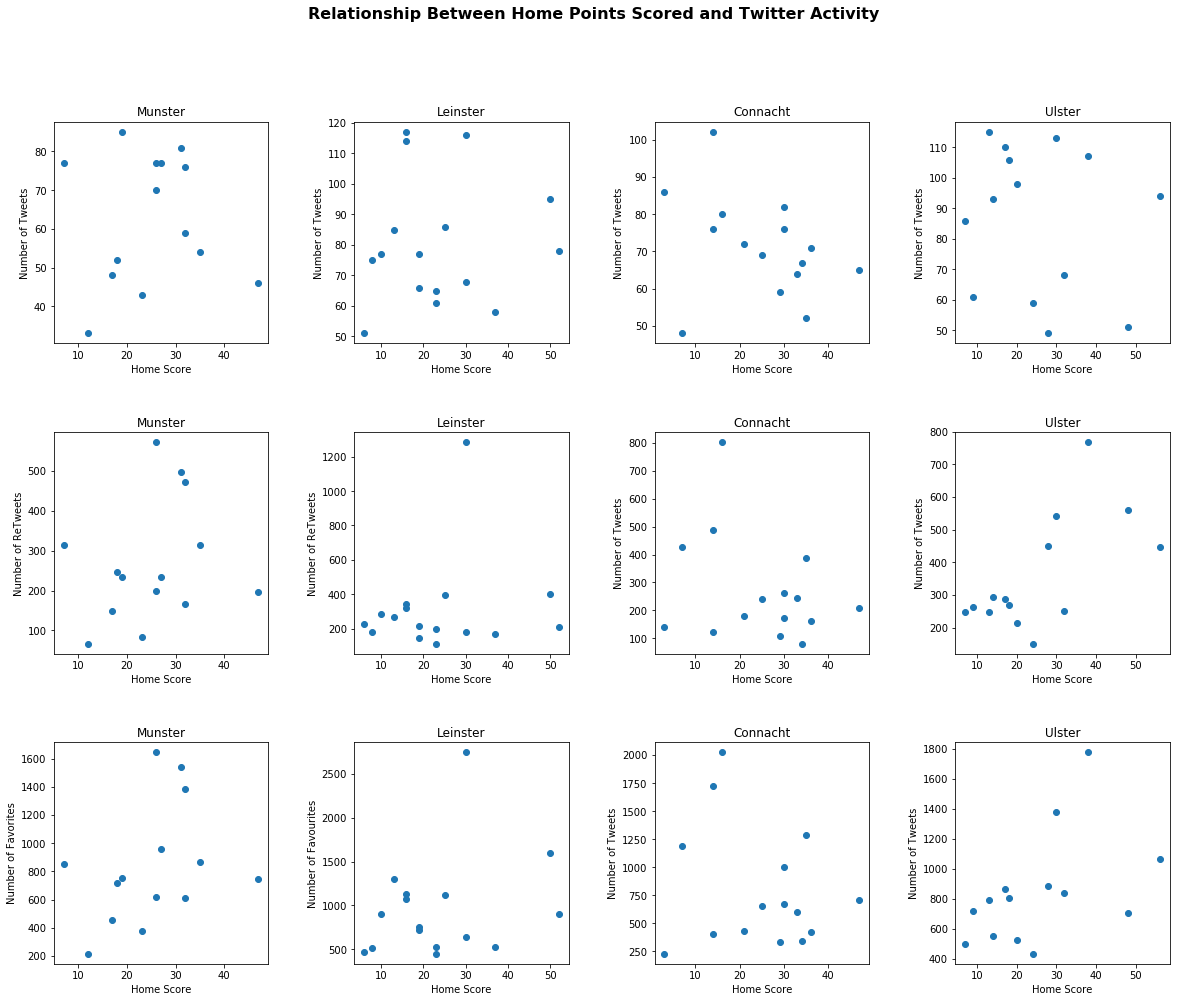

In [1115]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
fig.suptitle('Relationship Between Home Points Scored and Twitter Activity', fontsize=16, fontweight='bold')
fig.set_figheight(20)
fig.set_figwidth(20)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
#
fig.add_subplot(4,4,1)
plt.scatter(MunsterMatchData['Home Score'], MunsterMatchData['Number_tweets'])
plt.title("Munster")
plt.ylabel("Number of Tweets")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,5)
plt.scatter(MunsterMatchData['Home Score'], MunsterMatchData['Number_retweets'])
plt.title("Munster")
plt.ylabel("Number of ReTweets")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,9)
plt.scatter(MunsterMatchData['Home Score'], MunsterMatchData['Number_favorites'])
plt.title("Munster")
plt.ylabel("Number of Favorites")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,2)
plt.scatter(LeinsterMatchData['Home Score'], LeinsterMatchData['Number_tweets'])
plt.title("Leinster")
plt.ylabel("Number of Tweets")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,6)
plt.scatter(LeinsterMatchData['Home Score'], LeinsterMatchData['Number_retweets'])
plt.title("Leinster")
plt.ylabel("Number of ReTweets")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,10)
plt.scatter(LeinsterMatchData['Home Score'], LeinsterMatchData['Number_favorites'])
plt.title("Leinster")
plt.ylabel("Number of Favourites")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,3)
plt.scatter(ConnachtMatchData['Home Score'], ConnachtMatchData['Number_tweets'])
plt.title("Connacht")
plt.ylabel("Number of Tweets")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,7)
plt.scatter(ConnachtMatchData['Home Score'], ConnachtMatchData['Number_retweets'])
plt.title("Connacht")
plt.ylabel("Number of Tweets")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,11)
plt.scatter(ConnachtMatchData['Home Score'], ConnachtMatchData['Number_favorites'])
plt.title("Connacht")
plt.ylabel("Number of Tweets")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,4)
plt.scatter(UlsterMatchData['Home Score'], UlsterMatchData['Number_tweets'])
plt.title("Ulster")
plt.ylabel("Number of Tweets")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,8)
plt.scatter(UlsterMatchData['Home Score'], UlsterMatchData['Number_retweets'])
plt.title("Ulster")
plt.ylabel("Number of Tweets")
plt.xlabel("Home Score")
#
fig.add_subplot(4,4,12)
plt.scatter(UlsterMatchData['Home Score'], UlsterMatchData['Number_favorites'])
plt.title("Ulster")
plt.ylabel("Number of Tweets")
plt.xlabel("Home Score")

#### Explore whether Twitter Activity indicates the number of Total Points Scored
Investigate whether there is a stronger correlation between Twitter activity and the total points scored compared to just the home team's points.

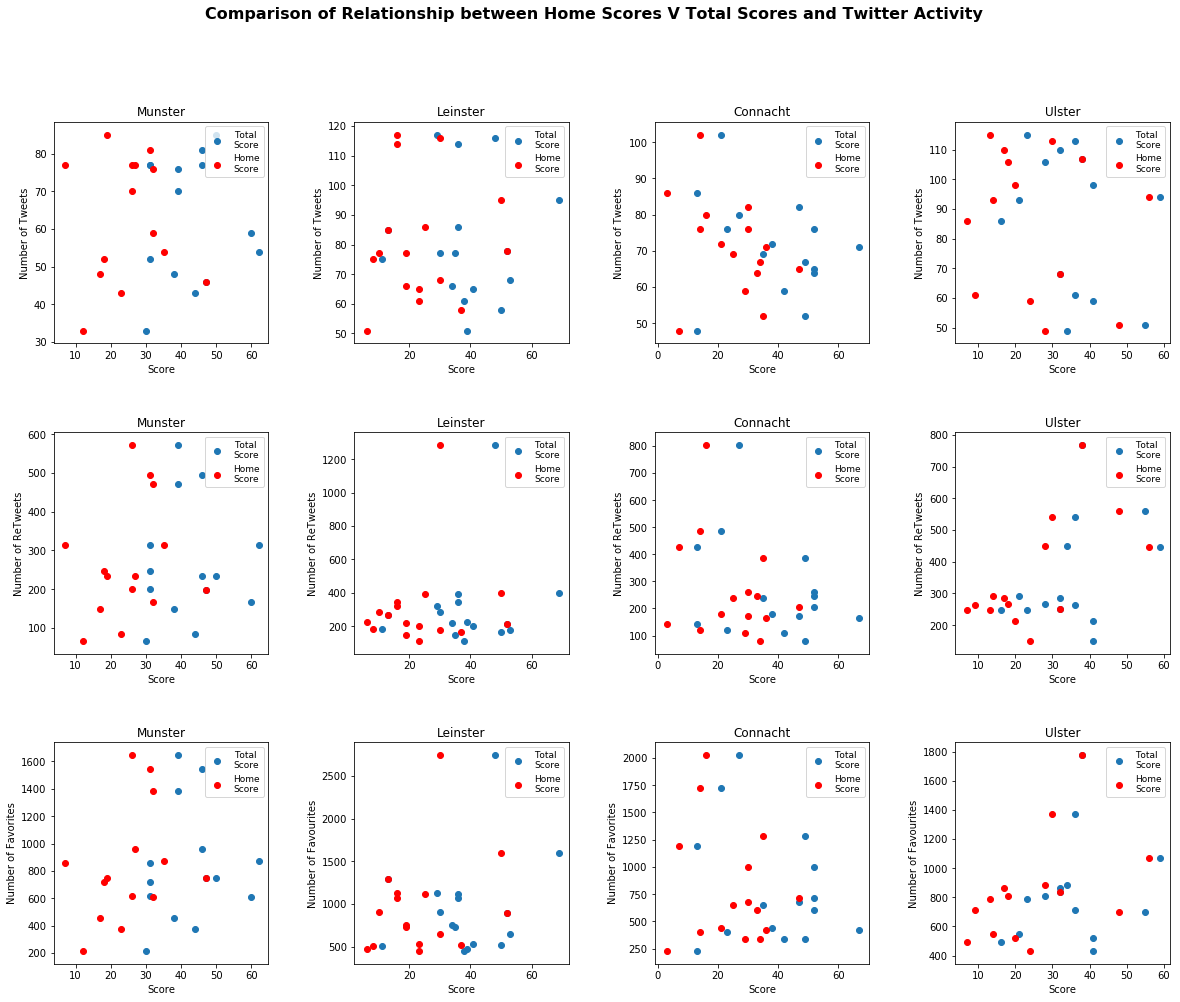

In [1130]:
fig = plt.figure()
fig.suptitle('Comparison of Relationship between Home Scores V Total Scores and Twitter Activity', fontsize=16, fontweight='bold')
fig.set_figheight(20)
fig.set_figwidth(20)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
#
fig.add_subplot(4,4,1)
plt.scatter(MunsterMatchData['Home Score']+MunsterMatchData['Away Score'], MunsterMatchData['Number_tweets'], label = 'Total\nScore')
fig.add_subplot(4,4,1)
plt.scatter(MunsterMatchData['Home Score'], MunsterMatchData['Number_tweets'], color = 'r', label = 'Home\nScore')
plt.title("Munster")
plt.ylabel("Number of Tweets")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,5)
plt.scatter(MunsterMatchData['Home Score']+MunsterMatchData['Away Score'], MunsterMatchData['Number_retweets'], label = 'Total\nScore')
fig.add_subplot(4,4,5)
plt.scatter(MunsterMatchData['Home Score'], MunsterMatchData['Number_retweets'], color = 'r', label = 'Home\nScore')
plt.title("Munster")
plt.ylabel("Number of ReTweets")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,9)
plt.scatter(MunsterMatchData['Home Score']+MunsterMatchData['Away Score'], MunsterMatchData['Number_favorites'], label = 'Total\nScore')
fig.add_subplot(4,4,9)
plt.scatter(MunsterMatchData['Home Score'], MunsterMatchData['Number_favorites'], color = 'r', label = 'Home\nScore')
plt.title("Munster")
plt.ylabel("Number of Favourites")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,2)
plt.scatter(LeinsterMatchData['Home Score']+LeinsterMatchData['Away Score'], LeinsterMatchData['Number_tweets'], label = 'Total\nScore')
fig.add_subplot(4,4,2)
plt.scatter(LeinsterMatchData['Home Score'], LeinsterMatchData['Number_tweets'], color = 'r', label = 'Home\nScore')
plt.title("Leinster")
plt.ylabel("Number of Tweets")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,6)
plt.scatter(LeinsterMatchData['Home Score']+LeinsterMatchData['Away Score'], LeinsterMatchData['Number_retweets'], label = 'Total\nScore')
fig.add_subplot(4,4,6)
plt.scatter(LeinsterMatchData['Home Score'], LeinsterMatchData['Number_retweets'], color = 'r', label = 'Home\nScore')
plt.title("Leinster")
plt.ylabel("Number of ReTweets")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,10)
plt.scatter(LeinsterMatchData['Home Score']+LeinsterMatchData['Away Score'], LeinsterMatchData['Number_favorites'], label = 'Total\nScore')
fig.add_subplot(4,4,10)
plt.scatter(LeinsterMatchData['Home Score'], LeinsterMatchData['Number_favorites'], color = 'r', label = 'Home\nScore')
plt.title("Leinster")
plt.ylabel("Number of Favourites")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,3)
plt.scatter(ConnachtMatchData['Home Score']+ConnachtMatchData['Away Score'], ConnachtMatchData['Number_tweets'], label = 'Total\nScore')
fig.add_subplot(4,4,3)
plt.scatter(ConnachtMatchData['Home Score'], ConnachtMatchData['Number_tweets'], color = 'r', label = 'Home\nScore')
plt.title("Connacht")
plt.ylabel("Number of Tweets")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,7)
plt.scatter(ConnachtMatchData['Home Score']+ConnachtMatchData['Away Score'], ConnachtMatchData['Number_retweets'], label = 'Total\nScore')
fig.add_subplot(4,4,7)
plt.scatter(ConnachtMatchData['Home Score'], ConnachtMatchData['Number_retweets'], color = 'r', label = 'Home\nScore')
plt.title("Connacht")
plt.ylabel("Number of ReTweets")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,11)
plt.scatter(ConnachtMatchData['Home Score']+ConnachtMatchData['Away Score'], ConnachtMatchData['Number_favorites'], label = 'Total\nScore')
fig.add_subplot(4,4,11)
plt.scatter(ConnachtMatchData['Home Score'], ConnachtMatchData['Number_favorites'], color = 'r', label = 'Home\nScore')
plt.title("Connacht")
plt.ylabel("Number of Favourites")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,4)
plt.scatter(UlsterMatchData['Home Score']+UlsterMatchData['Away Score'], UlsterMatchData['Number_tweets'], label = 'Total\nScore')
fig.add_subplot(4,4,4)
plt.scatter(UlsterMatchData['Home Score'], UlsterMatchData['Number_tweets'], color = 'r', label = 'Home\nScore')
plt.title("Ulster")
plt.ylabel("Number of Tweets")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,8)
plt.scatter(UlsterMatchData['Home Score']+UlsterMatchData['Away Score'], UlsterMatchData['Number_retweets'], label = 'Total\nScore')
fig.add_subplot(4,4,8)
plt.scatter(UlsterMatchData['Home Score'], UlsterMatchData['Number_retweets'], color = 'r', label = 'Home\nScore')
plt.title("Ulster")
plt.ylabel("Number of ReTweets")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})
#
fig.add_subplot(4,4,12)
plt.scatter(UlsterMatchData['Home Score']+UlsterMatchData['Away Score'], UlsterMatchData['Number_favorites'], label = 'Total\nScore')
fig.add_subplot(4,4,12)
plt.scatter(UlsterMatchData['Home Score'], UlsterMatchData['Number_favorites'], color = 'r', label = 'Home\nScore')
plt.title("Ulster")
plt.ylabel("Number of Favourites")
plt.xlabel("Score")
plt.legend(loc='upper right', prop={'size':9})

#### Explore whether Twitter Activity indicates the Result of a Match
To explore whether by examining the twitter activity of the home team, inferences can be made about the result of the match

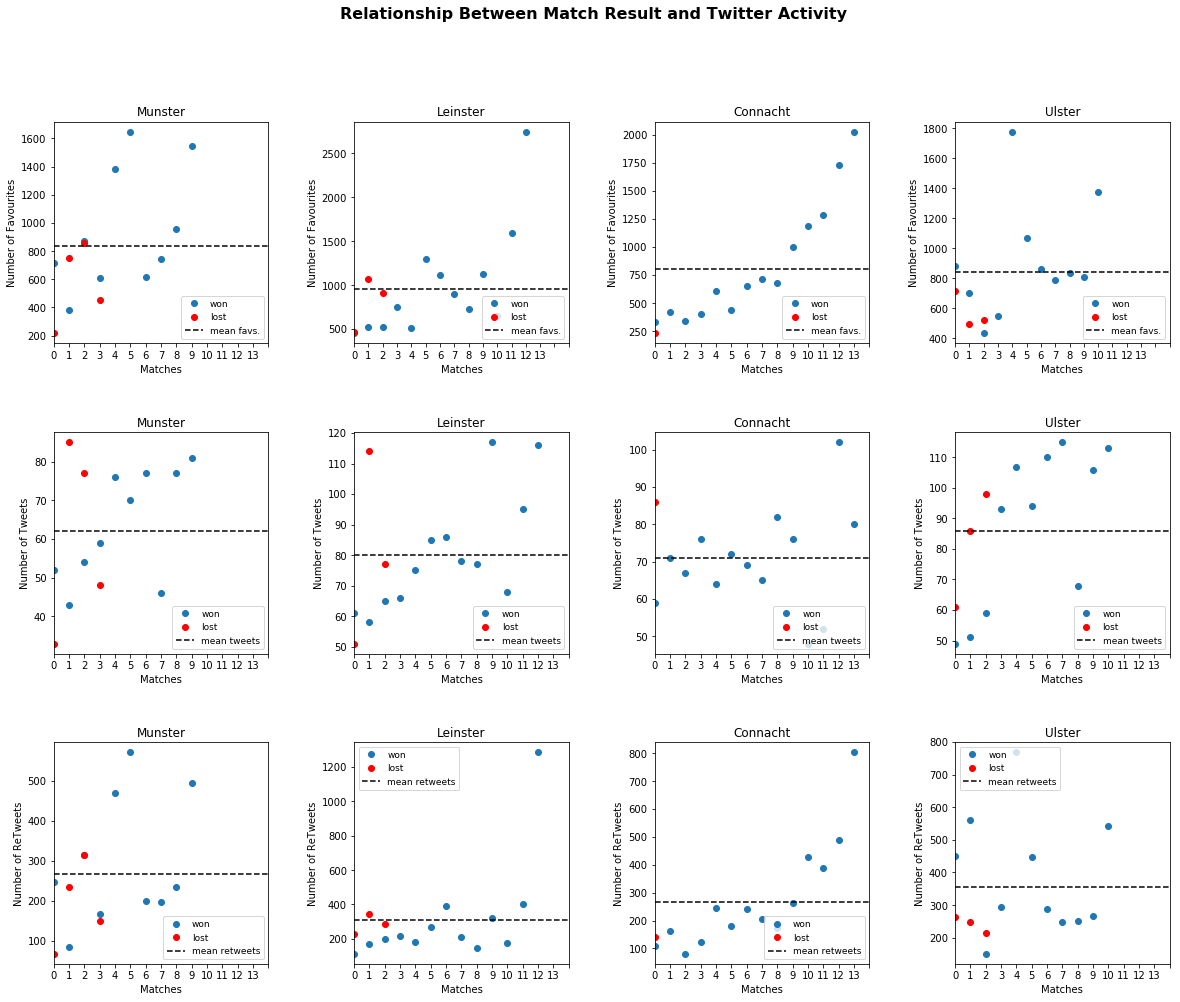

In [1123]:
fig = plt.figure()
fig.suptitle('Relationship Between Match Result and Twitter Activity', fontsize=16, fontweight='bold')
fig.set_figheight(20)
fig.set_figwidth(20)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
#
fig.add_subplot(4,4,1)
won = NFavsWonM.plot(x='Number_favorites', style='o',label = 'won')
lost = NFavsLostM.plot(x='Number_favorites', style='ro',label = 'lost')
plt.axhline(y=MeanNumFavM, color='k', linestyle='--',label = 'mean favs.')
plt.ylabel('Number of Favourites')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Munster')
plt.legend(loc='lower right', prop={'size':9})
#
fig.add_subplot(4,4,2)
won = NFavsWonL.plot(x='Number_favorites', style='o',label = 'won')
lost = NFavsLostL.plot(x='Number_favorites', style='ro',label = 'lost')
plt.axhline(y=MeanNumFavL, color='k', linestyle='--',label = 'mean favs.')
plt.ylabel('Number of Favourites')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Leinster')
plt.legend(loc='lower right', prop={'size':9})
#
fig.add_subplot(4,4,5)
won = NTweetsWonM.plot(x='Number_tweets', style='o',label = 'won')
lost = NTweetsLostM.plot(x='Number_tweets', style='ro',label = 'lost')
plt.axhline(y=MeanNumTweetsM, color='k', linestyle='--',label = 'mean tweets')
plt.ylabel('Number of Tweets')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Munster')
plt.legend(loc='lower right', prop={'size':9})
#
fig.add_subplot(4,4,6)
won = NTweetsWonL.plot(x='Number_tweets', style='o',label = 'won')
lost = NTweetsLostL.plot(x='Number_tweets', style='ro',label = 'lost')
plt.axhline(y=MeanNumTweetsL, color='k', linestyle='--',label = 'mean tweets')
plt.ylabel('Number of Tweets')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Leinster')
plt.legend(loc='lower right', prop={'size':9})
#
fig.add_subplot(4,4,9)
won = NReTweetsWonM.plot(x='Number_retweets', style='o',label = 'won')
lost = NReTweetsLostM.plot(x='Number_retweets', style='ro',label = 'lost')
plt.axhline(y=MeanNumReTweetsM, color='k', linestyle='--',label = 'mean retweets')
plt.ylabel('Number of ReTweets')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Munster')
plt.legend(loc='lower right', prop={'size':9})
#
fig.add_subplot(4,4,10)
won = NReTweetsWonL.plot(x='Number_retweets', style='o',label = 'won')
lost = NReTweetsLostL.plot(x='Number_retweets', style='ro',label = 'lost')
plt.axhline(y=MeanNumReTweetsL, color='k', linestyle='--',label = 'mean retweets')
plt.ylabel('Number of ReTweets')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Leinster')
plt.legend(loc='upper left', prop={'size':9})
#
fig.add_subplot(4,4,3)
won = NFavsWonC.plot(x='Number_favorites', style='o',label = 'won')
lost = NFavsLostC.plot(x='Number_favorites', style='ro',label = 'lost')
plt.axhline(y=MeanNumFavC, color='k', linestyle='--',label = 'mean favs.')
plt.ylabel('Number of Favourites')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Connacht')
plt.legend(loc='lower right', prop={'size':9})
#
fig.add_subplot(4,4,4)
won = NFavsWonU.plot(x='Number_favorites', style='o',label = 'won')
lost = NFavsLostU.plot(x='Number_favorites', style='ro',label = 'lost')
plt.axhline(y=MeanNumFavU, color='k', linestyle='--',label = 'mean favs.')
plt.ylabel('Number of Favourites')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Ulster')
plt.legend(loc='lower right', prop={'size':9})
#
fig.add_subplot(4,4,7)
won = NTweetsWonC.plot(x='Number_tweets', style='o',label = 'won')
lost = NTweetsLostC.plot(x='Number_tweets', style='ro',label = 'lost')
plt.axhline(y=MeanNumTweetsC, color='k', linestyle='--',label = 'mean tweets')
plt.ylabel('Number of Tweets')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Connacht')
plt.legend(loc='lower right', prop={'size':9})
#
fig.add_subplot(4,4,8)
won = NTweetsWonU.plot(x='Number_tweets', style='o',label = 'won')
lost = NTweetsLostU.plot(x='Number_tweets', style='ro',label = 'lost')
plt.axhline(y=MeanNumTweetsU, color='k', linestyle='--',label = 'mean tweets')
plt.ylabel('Number of Tweets')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Ulster')
plt.legend(loc='lower right', prop={'size':9})
#
fig.add_subplot(4,4,11)
won = NReTweetsWonC.plot(x='Number_retweets', style='o',label = 'won')
lost = NReTweetsLostC.plot(x='Number_retweets', style='ro',label = 'lost')
plt.axhline(y=MeanNumReTweetsC, color='k', linestyle='--',label = 'mean retweets')
plt.ylabel('Number of ReTweets')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Connacht')
plt.legend(loc='lower right', prop={'size':9})
#
fig.add_subplot(4,4,12)
won = NReTweetsWonU.plot(x='Number_retweets', style='o',label = 'won')
lost = NReTweetsLostU.plot(x='Number_retweets', style='ro',label = 'lost')
plt.axhline(y=MeanNumReTweetsU, color='k', linestyle='--',label = 'mean retweets')
plt.ylabel('Number of ReTweets')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('Ulster')
plt.legend(loc='upper left', prop={'size':9})

#### Combine Match Data from all Teams to examine general Trend
Combine data from all of the teams to see if a stronger correlation can be observed.

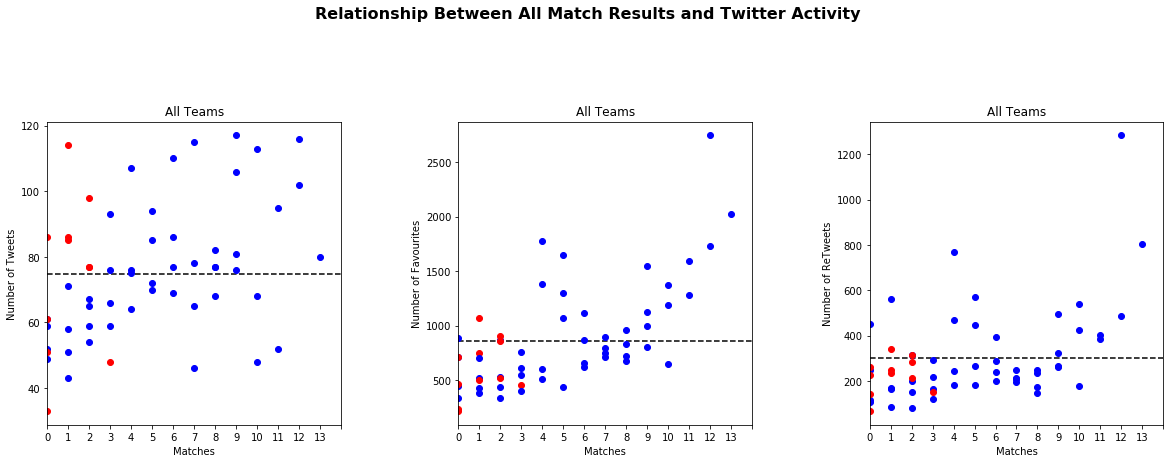

In [1119]:
fig = plt.figure()
fig.suptitle('Relationship Between All Match Results and Twitter Activity', fontsize=16, fontweight='bold')
fig.set_figheight(20)
fig.set_figwidth(20)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
#
fig.add_subplot(3,3,2)
plt.axhline(y=((MeanNumFavM + MeanNumFavL+MeanNumFavC + MeanNumFavU)/4) , color='k', linestyle='--',label = 'mean favs.')
won = NFavsWonM.plot(style='bo')
lost = NFavsLostM.plot(style='ro')
won = NFavsWonL.plot(style='bo')
lost = NFavsLostL.plot(style='ro')
won = NFavsWonC.plot(style='bo')
lost = NFavsLostC.plot(style='ro')
won = NFavsWonU.plot(style='bo')
lost = NFavsLostU.plot(style='ro')
plt.ylabel('Number of Favourites')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('All Teams')
#
fig.add_subplot(3,3,1)
plt.axhline(y=((MeanNumTweetsM+MeanNumTweetsL+MeanNumTweetsC+MeanNumTweetsU)/4), color='k', linestyle='--',label = 'mean tweets')
won = NTweetsWonM.plot(x='Number_tweets', style='bo')
lost = NTweetsLostM.plot(x='Number_tweets', style='ro')
won = NTweetsWonL.plot(x='Number_tweets', style='bo')
lost = NTweetsLostL.plot(x='Number_tweets', style='ro')
won = NTweetsWonC.plot(x='Number_tweets', style='bo')
lost = NTweetsLostC.plot(x='Number_tweets', style='ro')
won = NTweetsWonU.plot(x='Number_tweets', style='bo')
lost = NTweetsLostU.plot(x='Number_tweets', style='ro')
plt.ylabel('Number of Tweets')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('All Teams')
#
fig.add_subplot(3,3,3)
plt.axhline(y=((MeanNumReTweetsM+MeanNumReTweetsL+MeanNumReTweetsC+MeanNumReTweetsU)/4), color='k', linestyle='--',label = 'mean retweets')
won = NReTweetsWonM.plot(x='Number_retweets', style='bo',label = 'won')
lost = NReTweetsLostM.plot(x='Number_retweets', style='ro',label = 'lost')
won = NReTweetsWonL.plot(x='Number_retweets', style='bo',label = 'won')
lost = NReTweetsLostL.plot(x='Number_retweets', style='ro',label = 'lost')
won = NReTweetsWonC.plot(x='Number_retweets', style='bo',label = 'won')
lost = NReTweetsLostC.plot(x='Number_retweets', style='ro',label = 'lost')
won = NReTweetsWonU.plot(x='Number_retweets', style='bo',label = 'won')
lost = NReTweetsLostU.plot(x='Number_retweets', style='ro',label = 'lost')
plt.ylabel('Number of ReTweets')
plt.xlabel('Matches')
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
labels = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
plt.xticks(pos, labels)
plt.title('All Teams')

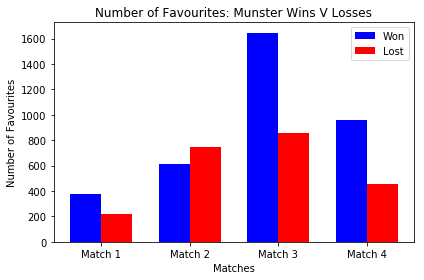

In [843]:
fig = plt.figure()
fig.suptitle('Relationship Between Match Result and Twitter Activity', fontsize=16, fontweight='bold')
fig.set_figheight(20)
fig.set_figwidth(20)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
#
fig.add_subplot(4,4,1)
n_matches = 4
Mwon = (NFavsWonM[1], NFavsWonM[3], NFavsWonM[5], NFavsWonM[8])
Mlost = (NFavsLostM[0], NFavsLostM[1], NFavsLostM[2], NFavsLostM[3])

#fig, ax = plt.subplots()
index = np.arange(n_matches)
bar_width = 0.35

rects1 = plt.bar(index, Mwon, bar_width,
                 color='b',
                 label='Won')
rects2 = plt.bar(index + bar_width, Mlost, bar_width,
                 color='r',
                 label='Lost')
plt.xlabel('Matches')
plt.ylabel('Number of Favourites')
plt.title('Number of Favourites: Munster Wins V Losses')
plt.xticks(index + bar_width / 2, ('Match 1', 'Match 2', 'Match 3', 'Match 4'))
plt.legend()
plt.tight_layout()
plt.show()

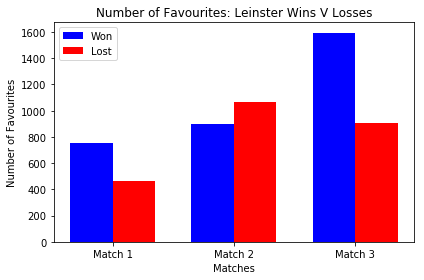

In [841]:
n_matches = 3

Lwon = (NFavsWonL[3], NFavsWonL[7], NFavsWonL[11])
Llost = (NFavsLostL[0], NFavsLostL[1], NFavsLostL[2])

fig, ax = plt.subplots()

index = np.arange(n_matches)
bar_width = 0.35

rects1 = plt.bar(index, Lwon, bar_width,
                 color='b',
                 label='Won')

rects2 = plt.bar(index + bar_width, Llost, bar_width,
                 color='r',
                 label='Lost')

plt.xlabel('Matches')
plt.ylabel('Number of Favourites')
plt.title('Number of Favourites: Leinster Wins V Losses')
plt.xticks(index + bar_width / 2, ('Match 1', 'Match 2', 'Match 3', 'Match 4'))
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.scatter(MunsterMatchData['Home Score'], MunsterMatchData['Number_tweets'], MunsterMatchData['Number_retweets'], MunsterMatchData['Number_favorites'])
plt.title("Relationship between Points Scored and Twitter Acitivity\n")
plt.ylabel("Number of Tweets")
plt.xlabel("Home Score")
plt.show()
plt.scatter(LeinsterMatchData['Home Score'], LeinsterMatchData['Number_tweets'], LeinsterMatchData['Number_retweets'], LeinsterMatchData['Number_favorites'])
plt.title("Relationship between Points Scored and Twitter Activity\n")
plt.ylabel("Number of Tweets")
plt.xlabel("Home Score")
plt.show()

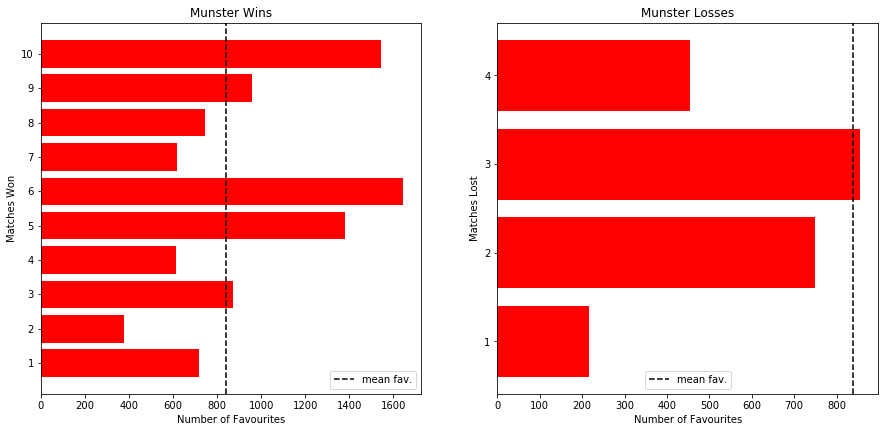

In [1124]:
valuesW= [NFavsWonM[0], NFavsWonM[1], NFavsWonM[2], NFavsWonM[3],NFavsWonM[4],NFavsWonM[5],NFavsWonM[6],NFavsWonM[7],NFavsWonM[8],NFavsWonM[9]]
labelsW = ["1","2","3","4","5","6","7","8","9","10"]
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
fig.add_subplot(2,2,1)   #top left
y_posW = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.barh(y_posW, valuesW, align='center',color='r')
plt.axvline(x=MeanNumFavM, color='k', linestyle='--', label='mean fav.')
plt.yticks(y_posW, labelsW)
plt.xlabel("Number of Favourites")
plt.ylabel("Matches Won")
plt.title("Munster Wins")
plt.legend()
fig.add_subplot(2,2,2)   #top right
valuesL= [NFavsLostM[0], NFavsLostM[1], NFavsLostM[2], NFavsLostM[3]]
labelsL = ["1","2","3","4"]
y_posL = [0, 1, 2, 3]
plt.barh(y_posL, valuesL, align='center', color='r')
plt.axvline(x=MeanNumFavM, color='k', linestyle='--',label='mean fav.')
plt.yticks(y_posL, labelsL)
plt.xlabel("Number of Favourites")
plt.ylabel("Matches Lost")
plt.title("Munster Losses")
plt.legend()

In [ ]:
valuesW= [NFavsWonL[0], NFavsWonL[1], NFavsWonL[2], NFavsWonL[3],NFavsWonL[4],NFavsWonL[5],NFavsWonL[6],NFavsWonL[7],NFavsWonL[8],NFavsWonL[9]]
labelsW = ["1","2","3","4","5","6","7","8","9","10"]
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
fig.add_subplot(2,2,1)   #top left
y_posW = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.barh(y_posW, valuesW, align='center',color='b')
plt.axvline(x=MeanNumFavL, color='g', linestyle='--', label='mean favs.')
plt.yticks(y_posW, labelsW)
plt.xlabel("Number of Favourites")
plt.ylabel("Matches Won")
plt.title("Leinster Wins")
plt.legend()
fig.add_subplot(2,2,2)   #top right
valuesL= [NFavsLostL[0], NFavsLostL[1], NFavsLostL[2]]
labelsL = ["1","2","3"]
y_posL = [0, 1, 2]
plt.barh(y_posL, valuesL, align='center')
plt.axvline(x=MeanNumFavL, color='g', linestyle='--',label='mean favs.')
plt.yticks(y_posL, labelsL)
plt.xlabel("Number of Favourites")
plt.ylabel("Matches Lost")
plt.title("Leinster Loss")
plt.legend()